<a href="https://colab.research.google.com/github/jtrinquier/SoftAlign/blob/main/SoftAlign_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
!  pip install git+https://github.com/deepmind/dm-haiku
import numpy as np
import string
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import pandas as pd
from jax.example_libraries.optimizers import adam
from jax.example_libraries.optimizers import sgd
import haiku as hk
import os
import re

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-9zohm3d8
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-9zohm3d8
  Resolved https://github.com/deepmind/dm-haiku to commit d14f1b62798a4da47cf3243cd87b1ad7dc52a108
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.14.dev0-py3-none-any.whl size=373712 sha256=2c85737f9209d05e4474bf99da254c2c3ce3d1b1ad1ed87fca28c2e6d53be9da
  Stored in directory: /tmp/pip-ephem-wheel-cache-34akqrln/wheels/86/29/0a/454c478e7217c383ee3d05aa43cbeff48284c23430f59d0c4f
Successfully built dm-haiku


In [ ]:
import utils

#tmalign

In [ ]:
%%bash
# get tmscore
wget -qnc https://zhanggroup.org/TM-score/TMscore.cpp
wget -qnc https://zhanggroup.org/TM-align/TMalign.cpp
g++ -static -O3 -ffast-math -lm -o TMscore TMscore.cpp
g++ -static -O3 -ffast-math -lm -o TMalign TMalign.cpp

In [ ]:
import os
def tmscore(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

In [ ]:
def tmalign(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMalign 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {"tms":[]}
  aln = []
  aln_mode = False
  for line in output:
    line = line.rstrip()
    if line.startswith("TM-score"): o["tms"].append(parse_float(line))
    if line.startswith('(":"'): aln_mode = True
    elif aln_mode == True and len(aln) < 3: aln.append(line)
    else: aln_mode = False

  o["aln"] = aln
  aln = []
  a,b = 0,0
  for n in range(len(o["aln"][0])):
    x = o["aln"][0][n]
    y = o["aln"][2][n]
    if x != "-":
      if y != "-": aln.append(b)
      else: aln.append(-1)
    if x != "-": a += 1
    if y != "-": b += 1

  o["aln"] = np.asarray(aln)
  return o

# Prepare the input, create train and test (different folds)


In [ ]:
# @title Training data, you can download the file using this link https://drive.google.com/file/d/1uMNq5tR-IafDu9Pv3sgO0YWwZfvr_6Lu/view?usp=drive_link

training_data_path = "aln_SCOPE" #@param {type:"string"}

list_pairs_ = pd.read_csv(training_data_path,header = None,sep = ",")

First Column: fold (SCOPE)

Second (third) column: id of first (second) protein (SCOPE)

Third Column: TM-score

Last column: TM-align alignment


In [ ]:
list_pairs_ = list_pairs_.drop_duplicates()
df = list_pairs_
unique_values = df[0].unique()

# set a fixed random seed
np.random.seed(42)

# randomly select n unique values from column 0
n = 1000 # for training
selected_values = np.random.choice(unique_values, n)

# select the rows that have the selected values in column 0
list_pairs = df[df[0].isin(selected_values)]

list_pairs_test = df[~df[0].isin(selected_values)]


In [ ]:
len(list_pairs[1].unique()) #number of proteins in the training set

6506

In [ ]:
len(list_pairs_test[1].unique()) #number of proteins in the test set

4705

In [ ]:
# @title TRAINING SET
list_pairs = list_pairs.rename(columns={0: "fold", 1: "name1", 2: "name2", 3: "TMS", 4: "aln"})
list_pairs


,fold,name1,name2,TMS,aln
0,a.1,d1dlwa_,d1dlwa_,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 ...
1,a.1,d1dlwa_,d2gkma_,0.93982,[ 12 13 14 15 16 17 18 19 20 21 22 ...
2,a.1,d1dlwa_,d2qrwa_,0.81432,[ 1 2 3 4 5 6 7 8 9 10 11 ...
3,a.1,d1dlwa_,d1s69a_,0.92695,[ 1 2 3 4 5 6 7 8 9 10 11 ...
4,a.1,d1dlwa_,d2bkma_,0.85270,[ 4 5 6 7 8 9 10 11 12 13 14 ...
...,...,...,...,...,...
1080309,g.88,d2ffta1,d2ffta1,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
1080312,g.91,d2b9da1,d2b9da1,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
1080313,g.91,d2b9da1,d2ewla1,0.79454,[-1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
1080314,g.91,d2ewla1,d2b9da1,0.79454,[-1 -1 1 2 3 4 5 6 7 8 9 10 11 12 13 ...


In [ ]:
# @title TEST_SET
list_pairs_test = list_pairs_test.rename(columns={0: "fold", 1: "name1", 2: "name2", 3: "TMS", 4: "aln"})
list_pairs_test


,fold,name1,name2,TMS,aln
4282,a.3,d1gu2a_,d1gu2a_,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 ...
4283,a.3,d1gu2a_,d2c8sa1,0.49401,[ -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
4284,a.3,d1gu2a_,d1i8oa_,0.37712,[ -1 -1 -1 -1 -1 0 -1 -1 1 -1 -1 ...
4285,a.3,d1gu2a_,d1cc5a_,0.41910,[-1 -1 -1 -1 -1 -1 -1 -1 0 -1 -1 -1 -1 -1 -1 ...
4286,a.3,d1gu2a_,d1gksa_,0.40663,[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
...,...,...,...,...,...
1080308,g.87,d2baia1,d2baia1,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
1080310,g.89,d2dkta1,d2dkta1,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
1080311,g.90,d2fk4a1,d2fk4a1,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
1080316,g.92,d2pkgc1,d2pkgc1,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...


In [ ]:
list_pairs = list_pairs.reset_index(drop=True)
list_pairs_test = list_pairs_test.reset_index(drop=True)

In [ ]:
# @title Download here https://drive.google.com/file/d/1DFWcUgPukTxWGPUxaeTM1kNEVNCkRgbO/view?usp=sharing
# inputs of ProteinMPNN
import pickle
with open("dicti_inputs_SCOPE_colab",'rb') as fff:
  dicti_inputs = pickle.load(fff)

In [ ]:
#@title Input of the model
#####0.5
max_size = 300 #@param {type:"integer"} #maximum length
threshold = 0.5 #@param  # minimum tm-score



X1 = [];X2 = [];mask1 = [];mask2 = [];chain1 = [];chain2 = [];res1 = [];res2 = []

id1 = []
id2 = []


tmaln = []
for k in range(len(list_pairs)):

  pr1,pr2 = list_pairs["name1"][k],list_pairs["name2"][k]
  if pr1 in dicti_inputs.keys() and pr2 in dicti_inputs.keys() and list_pairs["TMS"][k]>threshold:
    _X1,_mask1,_chain1,_res1 = dicti_inputs[pr1]
    _X2,_mask2,_chain2,_res2 = dicti_inputs[pr2]
    if len(_X1[0])<=max_size and len(_X2[0])<=max_size:
      id1.append(pr1)
      id2.append(pr2)
      X1.append(_X1[0]);X2.append(_X2[0])
      mask1.append(_mask1[0]); mask2.append(_mask2[0])
      chain1.append(_chain1[0]); chain2.append(_chain2[0])
      res1.append(_res1[0]); res2.append(_res2[0])
      tmaln.append(np.array([int(s) for s in re.findall(r'-?\d+', list_pairs["aln"][k])]))


###Different folds

max_size2= 300
X1tt = [];X2tt = [];mask1tt = [];mask2tt = [];chain1tt = [];chain2tt = [];res1tt = [];res2tt = []

id1tt = []
id2tt = []
tmalntt = []

for k in range(len(list_pairs_test)):
  pr1,pr2 = list_pairs_test["name1"][k],list_pairs_test["name2"][k]
  if pr1 in dicti_inputs.keys() and pr2 in dicti_inputs.keys() and list_pairs_test["TMS"][k]>threshold:
    _X1,_mask1,_chain1,_res1 = dicti_inputs[pr1]
    _X2,_mask2,_chain2,_res2 = dicti_inputs[pr2]
    if len(_X1[0])<=max_size2 and len(_X2[0])<=max_size2:
      id1tt.append(pr1)
      id2tt.append(pr2)
      X1tt.append(_X1[0]);X2tt.append(_X2[0])
      mask1tt.append(_mask1[0]); mask2tt.append(_mask2[0])
      chain1tt.append(_chain1[0]); chain2tt.append(_chain2[0])
      res1tt.append(_res1[0]); res2tt.append(_res2[0])
      tmalntt.append(np.array([int(s) for s in re.findall(r'-?\d+', list_pairs_test["aln"][k])]))



# Initialization

In [ ]:
import END_TO_END_MODELS as ete
import Loss_functions as loss_


In [ ]:
num_layers = 3 #@param {type:"integer"}
num_neighbors = 64 #@param {type:"integer"}
encoding_dim = 64 #@param {type:"integer"}
categorical = False #@param {type:"boolean"}
nb_clusters = 20 #@param {type:"integer"}
soft_max = True #@param {type:"boolean"}
bs = 15


def model_end_to_end(x1,x2,lens,t,node_features = encoding_dim,
                 edge_features = encoding_dim, hidden_dim = encoding_dim,
                 num_encoder_layers=num_layers,
                  k_neighbors=num_neighbors,categorical = categorical,nb_clusters = nb_clusters,affine = True,soft_max = soft_max):
  if categorical:
    a = ete.END_TO_END_SEQ_KMEANS(node_features,edge_features,hidden_dim,num_encoder_layers,k_neighbors,nb_clusters = nb_clusters,affine = True,soft_max = soft_max,dropout = 0.)
  else:
    a = ete.END_TO_END(node_features,edge_features,hidden_dim,num_encoder_layers,k_neighbors,affine = True,soft_max = soft_max,dropout = 0.)
  return a(x1,x2,lens,t)

In [ ]:
# @title Init params
tmaln = np.array(tmaln,dtype=object)


nb_test = 100 #@param {type:"number"}

dicti_train_test = utils.create_test_train(np.array(id1),np.array(id2),np.array(X1,dtype=object),np.array(X2,dtype=object),np.array(chain1,dtype=object),np.array(chain2,dtype=object),np.array(mask1,dtype=object),np.array(mask2,dtype=object),np.array(res1,dtype=object),np.array(res2,dtype=object),nb_test = nb_test,tma = True,tmaln = tmaln)

X_1,X_2,chain_1,chain_2,mask_1,mask_2,res_1,res_2,tmaln = dicti_train_test["train"]


MODEL_ETE = hk.transform(model_end_to_end)
key = jax.random.PRNGKey(0)
X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens = utils.pad_(X_1[:bs],mask_1[:bs],res_1[:bs],chain_1[:bs],X_2[:bs],mask_2[:bs],res_2[:bs],chain_2[:bs],max_size)
x1 = X1,mask1,res1,chain1
x2 = X2,mask2,res2,chain2

params = MODEL_ETE.init(key,x1,x2,lens,1)

308571
nb of training pairs 274391


In [ ]:
params['~']['gap']

Array([-0.8758356], dtype=float32)

In [ ]:
params['~']['open']

Array([-2.793947], dtype=float32)

In [ ]:
opt_init, opt_update, get_params = adam(1/1e3)
opt_state = opt_init(params)

if categorical:
  @jax.jit
  def train_step(step_i, opt_state, loss_data):
      net_params = get_params(opt_state)
      (loss,aux), grads = jax.value_and_grad(loss_.CrossEntropyLoss_CAT, argnums=0,has_aux=True)(net_params, loss_data,MODEL_ETE)

      return (loss,aux), opt_update(step_i, grads, opt_state)
else:
  @jax.jit
  def train_step(step_i, opt_state, loss_data):
      net_params = get_params(opt_state)
      (loss,aux), grads = jax.value_and_grad(loss_.CrossEntropyLoss, argnums=0,has_aux=True)(net_params, loss_data,MODEL_ETE)

      return (loss,aux), opt_update(step_i, grads, opt_state)

# Training


In [ ]:
#@title Training
np.random.seed()
epochs = 50 #@param {type:"integer"}
T_start = 3 #@param {type:"number"}
T_end = 1 #@param {type:"number"}
#np.random.seed(1)
bs = 20
nb_b = int((len(X_1))//bs-1)
print(nb_b)

for j in range(epochs
               ):
    t = T_start-(j/epochs)*(T_start-T_end)

    print("Temperature: ",t)
    print("Epoch: ",j)




    losses = [] ## Record loss of each batch
    batch = np.random.randint(0,nb_b,500)
    for k,i in enumerate(batch):
      X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens = utils.pad_tmalign(X_1[i*bs:(i+1)*bs],mask_1[i*bs:(i+1)*bs],res_1[i*bs:(i+1)*bs],chain_1[i*bs:(i+1)*bs],X_2[i*bs:(i+1)*bs],mask_2[i*bs:(i+1)*bs],res_2[i*bs:(i+1)*bs],chain_2[i*bs:(i+1)*bs],tmaln[i*bs:(i+1)*bs],max_size)
      x1 = X1,mask1,res1,chain1
      x2 = X2,mask2,res2,chain2
      mask__1 = np.zeros((bs,max_size,max_size))
      mask__2 = np.zeros((bs,max_size,max_size))

      for jj in range(X1.shape[0]):
          mask__1[jj,:lens[jj,0],:lens[jj,0]] = 1
          mask__2[jj,:lens[jj,1],:lens[jj,1]] = 1
      x = X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens,t#,mask__1,mask__2


      (loss,aux), opt_state = train_step(j, opt_state, x)

      if (k+1)%25==0:
        print(i)
        print(loss,"loss batch")
        if categorical:
          print(np.argmax(aux["seqs"][0][0],-1))
      losses.append(loss)

    print("Loss : {:.3f}".format(jnp.array(losses).mean()))

13718
Temperature:  3.0
Epoch:  0
3753
414.8895 loss batch
10666
333.7022 loss batch
2918
286.36206 loss batch
1748
253.26843 loss batch
Loss : 365.829
Temperature:  2.96
Epoch:  1
2743
240.2072 loss batch
12908
299.2551 loss batch
1829
285.9432 loss batch
9867
199.64888 loss batch
Loss : 256.455
Temperature:  2.92
Epoch:  2
5442
237.22343 loss batch
6342
229.69131 loss batch
13611
195.46227 loss batch
13132
228.75224 loss batch
Loss : 221.629
Temperature:  2.88
Epoch:  3
11121
207.8428 loss batch
6416
178.30296 loss batch
801
224.42119 loss batch
489
209.78735 loss batch
Loss : 198.576
Temperature:  2.84
Epoch:  4
7487
199.00114 loss batch
8414
155.02397 loss batch
11200
180.64478 loss batch
3543
214.46788 loss batch
Loss : 187.296
Temperature:  2.8
Epoch:  5
11295
254.69832 loss batch
1655
212.55154 loss batch
7264
192.7728 loss batch
8912
155.52525 loss batch
Loss : 184.694
Temperature:  2.76
Epoch:  6
13104
165.66342 loss batch
10109
166.6922 loss batch
3639
177.61504 loss batch
14

In [ ]:
params = get_params(opt_state)

print(params['~']['gap'])
print(params['~']['open'])


[0.05896761]
[-3.2550347]


# True test, different folds

In [ ]:
import LDDT_LOSS as lddt

In [ ]:
t = 10**-4

In [ ]:
@jax.jit
def align(input_data,weights):
  X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens,t = input_data
  x1 = X1,mask1,res1,chain1
  x2 = X2,mask2,res2,chain2
  return MODEL_ETE.apply(weights,key, x1,x2,lens,t)[0],MODEL_ETE.apply(weights,key, x1,x2,lens,t)[1]

In [ ]:
import random


n_samples = 1000
random.seed(123)  # fix the seed to 123 for reproducibility
print(len(X1tt))
indices = random.sample(range(len(X1tt)), n_samples)
X_1t = [X1tt[i] for i in indices]
X_2t = [X2tt[i] for i in indices]
chain_1t = [chain1tt[i] for i in indices]
chain_2t = [chain2tt[i] for i in indices]
mask_1t = [mask1tt[i] for i in indices]
mask_2t = [mask2tt[i] for i in indices]
res_1t = [res1tt[i] for i in indices]
res_2t = [res2tt[i] for i in indices]
tmalnt = [tmalntt[i] for i in indices]

92148


In [ ]:
import Score_align as score_

In [ ]:
k = 1000
bs = 50
params = get_params(opt_state)
max_size2 = 300
max_size = 300
X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens = utils.pad_tmalign(X_1t,mask_1t,res_1t,chain_1t,X_2t,mask_2t,res_2t,chain_2t,tmalnt,max_size2)
print(len(mask_2t),len(tmalnt))
print(len(X1))

score_reconstruc = np.zeros(k)
score_tm = np.zeros(k)
score_reconstruc_lddt = np.zeros(k)
score_tm_lddt = np.zeros(k)

for i in range(k//bs):
#for i in range(2):
  print(i)
  input_data = X1[i*bs:(i+1)*bs],mask1[i*bs:(i+1)*bs],res1[i*bs:(i+1)*bs],chain1[i*bs:(i+1)*bs],X2[i*bs:(i+1)*bs],mask2[i*bs:(i+1)*bs],res2[i*bs:(i+1)*bs],chain2[i*bs:(i+1)*bs],lens[i*bs:(i+1)*bs],t
  soft_aln,sim = align(input_data,params)
  soft_aln = np.array(soft_aln)
  soft_aln[soft_aln<10**-2] = 0
  soft_aln = jnp.array(soft_aln)

  mask__1 = np.zeros((bs,max_size,max_size))
  mask__2 = np.zeros((bs,max_size,max_size))
  for j in range(bs):

      mask__1[j,:lens[i*bs+j,0],:lens[i*bs+j,0]] = 1
      mask__2[j,:lens[i*bs+j,1],:lens[i*bs+j,1]] = 1
  score_reconstruc_lddt[i*bs:(i+1)*bs] = lddt.get_LDDTloss(X1[i*bs:(i+1)*bs][:,:,1],X2[i*bs:(i+1)*bs][:,:,1],soft_aln,lens[i*bs:(i+1)*bs],mask__1,mask__2,t, max1 = max_size)
  score_tm_lddt[i*bs:(i+1)*bs] = lddt.get_LDDTloss(X1[i*bs:(i+1)*bs][:,:,1],X2[i*bs:(i+1)*bs][:,:,1],jax.nn.one_hot(TMALN[i*bs:(i+1)*bs],max_size),lens[i*bs:(i+1)*bs],mask__1,mask__2,t, max1 = max_size)

  for j in range(bs):

    temp1 = tmscore(X_1t[i*bs+j][:,1],jax.nn.one_hot(TMALN[i*bs+j][:lens[i*bs+j][0]],lens[i*bs+j][1])@X_2t[i*bs+j][:,1])
    score_tm[j+i*bs] = temp1["tms"]
    temp2 = tmscore(X_1t[i*bs+j][:,1],soft_aln[j,:lens[i*bs+j][0],:lens[i*bs+j][1]]@X_2t[i*bs+j][:,1])
    score_reconstruc[j+i*bs] = temp2["tms"]

1000 1000
1000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
print(score_reconstruc_lddt[score_tm>0.6].mean())

0.5221220551175065


In [ ]:
print(score_tm_lddt[score_tm>0.6].mean())

0.5690637475345284


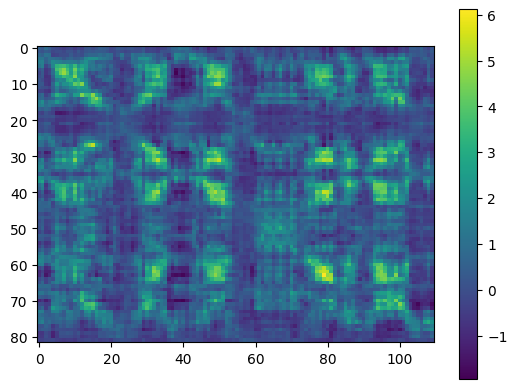

In [ ]:

plt.imshow(sim[j, :lens[i * bs + j][0], :lens[i * bs + j][1]])
plt.colorbar()

Text(0.5, 1.0, 'Tm-align alignment')

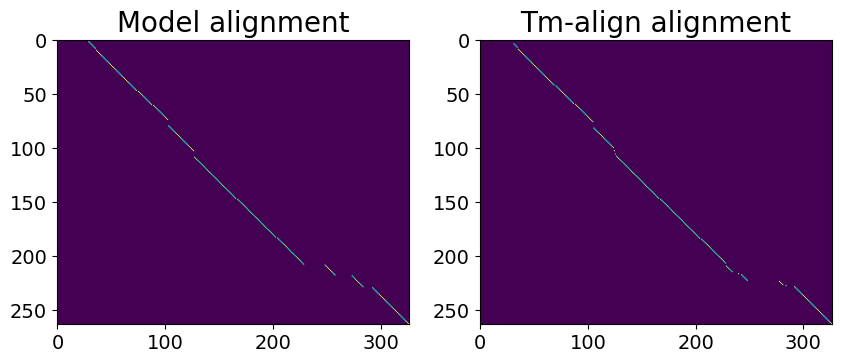

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, this is the first subplot
plt.imshow(soft_aln[j, :lens[i * bs + j][0], :lens[i * bs + j][1]])
plt.title("Model alignment")

# Set up the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, this is the second subplot
plt.imshow(jax.nn.one_hot(TMALN[i * bs + j][:lens[i * bs + j][0]], lens[i * bs + j][1]))
plt.title("Tm-align alignment")

0.3698691081441939 0.3768627663888037
(-0.010504858940839773, 1.048119278997183)


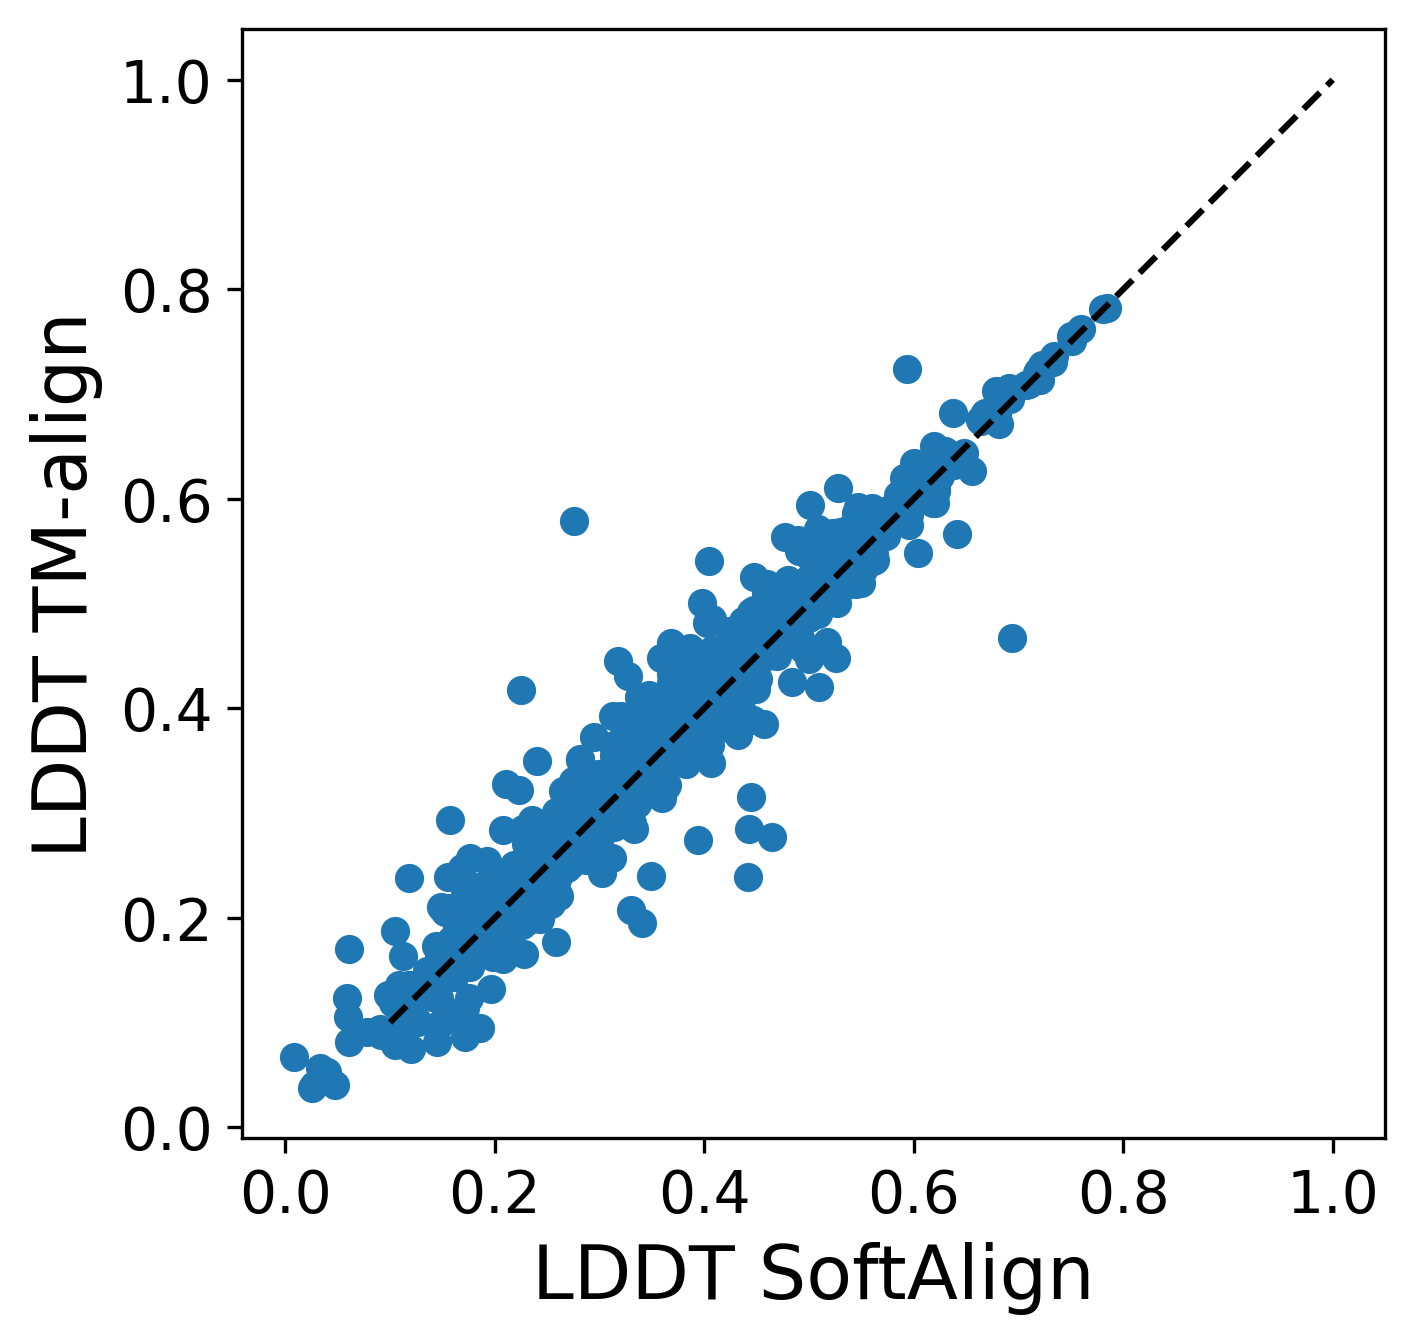

In [ ]:
import matplotlib.pyplot as plt
# Set global font sizes
plt.rcParams.update({
    'font.size': 16,           # General font size
    'axes.titlesize': 20,      # Title font size
    'axes.labelsize': 18,      # Axis label font size
    'xtick.labelsize': 14,     # X-tick label font size
    'ytick.labelsize': 14,     # Y-tick label font size
    'legend.fontsize': 16,     # Legend font size
})

# Create the main figure and plot
plt.figure(dpi=300)
plt.scatter(score_reconstruc_lddt,score_tm_lddt)
print(score_reconstruc_lddt.mean(),score_tm_lddt.mean())
plt.xlabel("LDDT SoftAlign")
plt.ylabel("LDDT TM-align")
plt.plot([0.1,1],[0.1,1],"--k")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
print(ylim)
# Set the aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

0.49221 0.5417627
(0.09154000000000001, 1.04326)


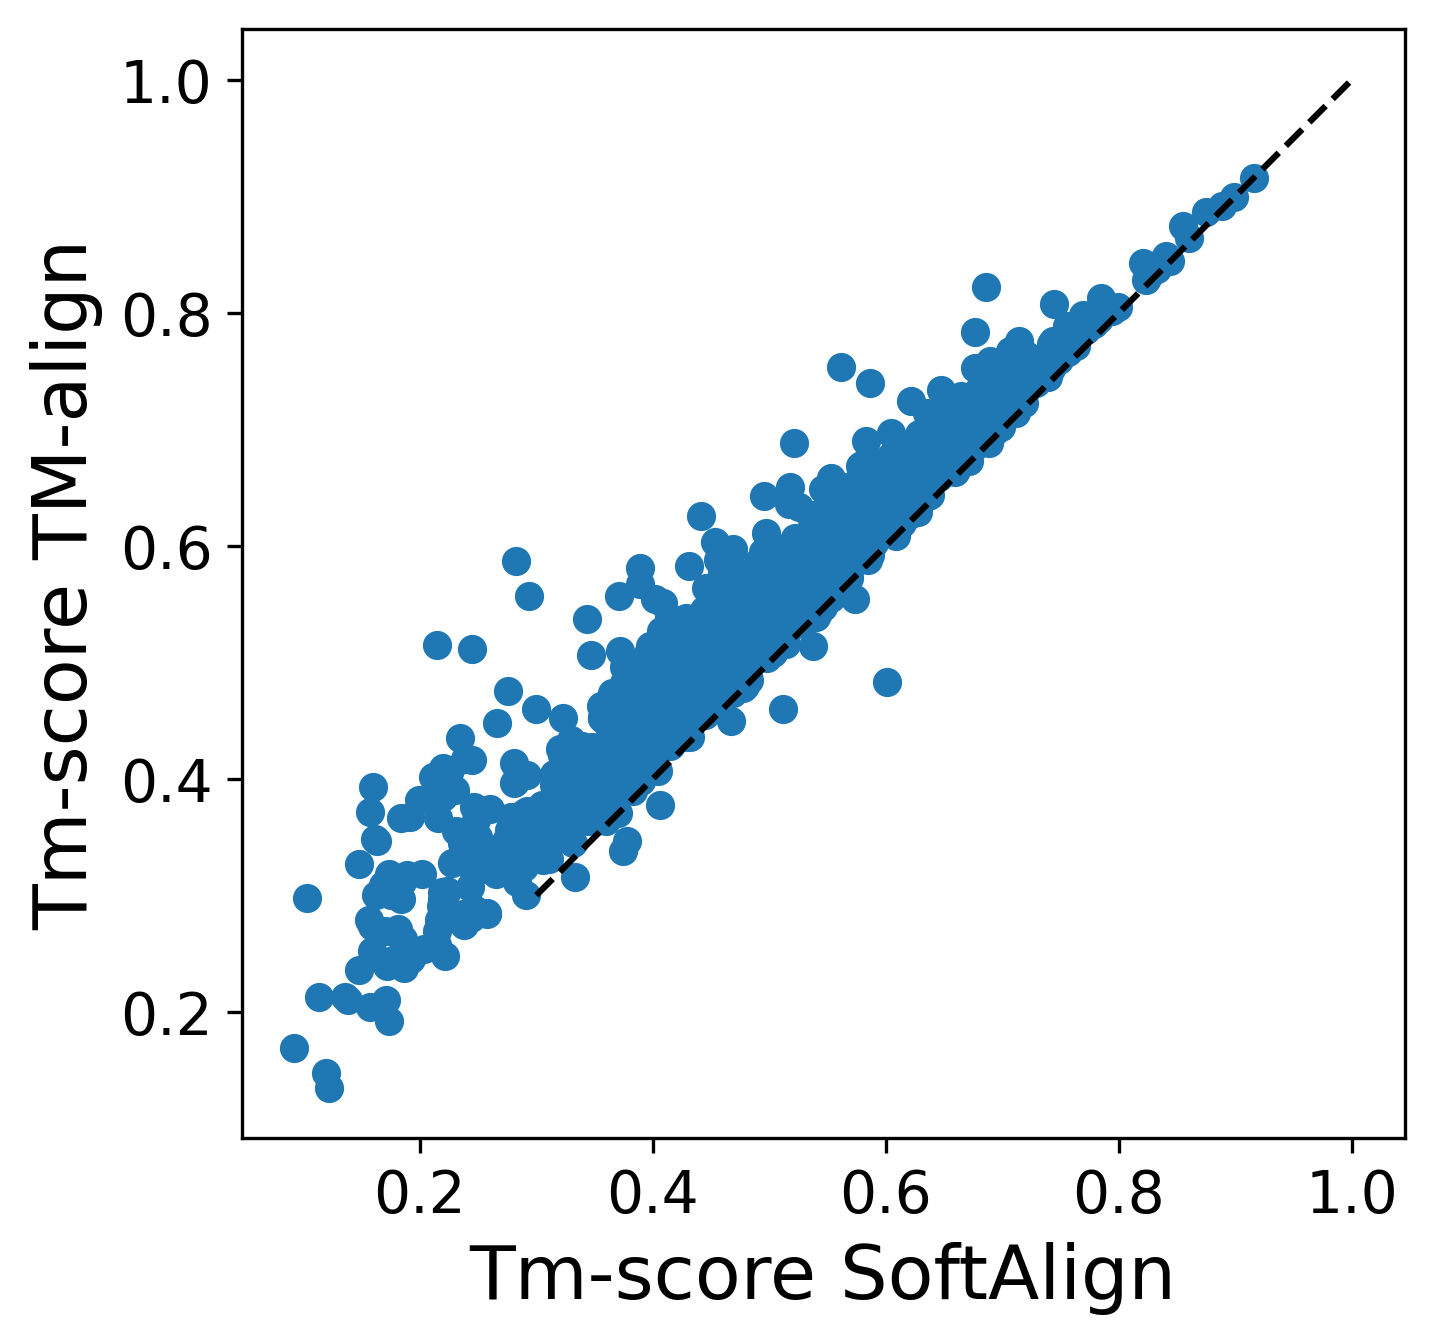

In [ ]:
plt.figure(dpi = 300)
plt.scatter(score_reconstruc,score_tm)
print(score_reconstruc.mean(),score_tm.mean())
#square = patches.Rectangle((0.6, 0.6), 0.4, 0.4, linewidth=1, edgecolor='r', facecolor='none')
#plt.gca().add_patch(square)

plt.xlabel("Tm-score SoftAlign")
plt.ylabel("Tm-score TM-align")
plt.plot([0.3,1],[0.3,1],"--k")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
print(ylim)
ax.set_aspect('equal', adjustable='box')